# Loan Interest Rate Prediction
This notebook utilizes Python and key libraries (Pandas, NumPy, scikit-learn, and Matplotlib) to analyze and predict loan interest rates based on a number of factors such as income level, purpose of the loan, FICO credit score, debt-to-income ratio

## Data
We will be exploring publicly available data from LendingClub.com. Lending Club connects people who need money (borrowers) with people who have money(investors).  
Link to dataset: https://www.kaggle.com/datasets/sahilnbajaj/loans-data

## Importance of Predicting Loan Interest Rates

Predicting loan interest rates is a critical aspect of financial decision-making for both lenders and borrowers. Lenders use interest rates to assess the risk of lending money to individuals, assigning higher rates to those deemed riskier based on factors like credit score, debt-to-income ratio, and income. For borrowers, understanding the factors that affect their interest rates can help them make informed financial decisions, like improving their creditworthiness before applying for a loan.

By building machine learning models to predict loan interest rates, financial institutions can:
- **Improve Risk Assessment**: More accurate predictions of interest rates can help institutions evaluate the likelihood of loan defaults, leading to better lending decisions.
- **Personalize Loan Offers**: With predictive models, lenders can offer more personalized interest rates to customers, improving customer satisfaction and competitiveness in the market.
- **Enhance Operational Efficiency**: Automation of the interest rate prediction process can reduce manual work, speeding up loan approval times and improving operational efficiency.

For borrowers, these models provide transparency into the loan approval process, helping them understand how their financial profile affects the interest rates they receive and what actions they can take to secure more favorable terms.



## Data Dictionary:
- **credit.policy**: 1 if the customer meets the credit underwriting criteria of LendingClub.com, and 0 otherwise.
- **purpose**: The purpose of the loan (values: "credit_card", "debt_consolidation", "educational", "major_purchase", "small_business", "all_other").
- **int.rate**: The interest rate of the loan, as a proportion (e.g., a rate of 11% would be stored as 0.11). Borrowers judged as more risky are assigned higher interest rates.
- **installment**: The monthly installments owed by the borrower if the loan is funded.
- **log.annual.inc**: The natural log of the self-reported annual income of the borrower.
- **dti**: The debt-to-income ratio of the borrower (amount of debt divided by annual income).
- **fico**: The FICO credit score of the borrower.
- **days.with.cr.line**: The number of days the borrower has had a credit line.
- **revol.bal**: The borrower's revolving balance (amount unpaid at the end of the credit card billing cycle).
- **revol.util**: The borrower's revolving line utilization rate (the amount of the credit line used relative to total credit available).
- **inq.last.6mths**: The borrower's number of inquiries by creditors in the last 6 months.
- **delinq.2yrs**: The number of times the borrower has been 30+ days past due on a payment in the past 2 years.
- **pub.rec**: The borrower's number of derogatory public records (e.g., bankruptcy filings, tax liens, or judgments).

### Target Variable: **Interest Rate**

## Machine Learning Models Used:
- Random Forest
- Linear Regression
- Ridge Regression
- Gradient Boosting
- XG Boost
- CatBoost

### Goal: Mean Absolute Error (MAE) <= 0.01
**Mean absolute error (MAE)** measures the average magnitude of errors in predictions, without considering their direction. It’s in the same units as the target variable. 

**Smaller MAE values are better**  

* **Low MAE (~0.01 or less)**: If MAE is around 0.01, it means that, on average, the model's predictions deviate by 1% from the actual interest rates. This would be considered very good for predicting loan interest rates.
* **Moderate MAE (0.01 - 0.05)**: An MAE in this range would suggest reasonably accurate predictions but could still lead to noticeable deviations, especially for customers at the edge of creditworthiness or for loans with sensitive pricing.
* **High MAE (above 0.05)**: If the MAE exceeds 5%, the predictions may not be accurate enough for business-critical decisions like loan approval or setting interest rates. This level of error could be problematic for practical use in the financial industry.


## Importing Our Tools

In [251]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error

from xgboost import XGBRegressor
from catboost import CatBoostRegressor

## Load and View Data

In [252]:
data = pd.read_csv('loan_data.csv')
data.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


In [253]:
len(data)

9578

In [254]:
data.isnull().sum()

credit.policy        0
purpose              0
int.rate             0
installment          0
log.annual.inc       0
dti                  0
fico                 0
days.with.cr.line    0
revol.bal            0
revol.util           0
inq.last.6mths       0
delinq.2yrs          0
pub.rec              0
not.fully.paid       0
dtype: int64

In [255]:
data.dtypes

credit.policy          int64
purpose               object
int.rate             float64
installment          float64
log.annual.inc       float64
dti                  float64
fico                   int64
days.with.cr.line    float64
revol.bal              int64
revol.util           float64
inq.last.6mths         int64
delinq.2yrs            int64
pub.rec                int64
not.fully.paid         int64
dtype: object

In [256]:
zero=data[data['credit.policy']==0]
zero.head(10)

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
7710,0,debt_consolidation,0.1608,35.20,10.308953,23.84,642,2490.000000,10125,90.4,1,0,0,0
7711,0,debt_consolidation,0.1608,246.38,12.152144,22.47,647,7212.000000,150971,92.3,4,0,0,1
7712,0,debt_consolidation,0.1600,787.53,11.264464,19.34,682,3780.041667,15897,66.0,5,0,1,0
7713,0,educational,0.1640,126.40,10.308953,29.60,677,1643.000000,3043,58.5,1,0,0,1
7714,0,debt_consolidation,0.1482,242.05,10.714418,19.12,652,2847.000000,26531,52.6,33,0,0,1
7715,0,debt_consolidation,0.1482,172.89,10.645425,18.51,652,4020.000000,9792,64.0,8,0,0,1
7716,0,debt_consolidation,0.1380,149.96,10.736397,16.70,662,4339.000000,314,12.6,4,1,0,0
7717,0,all_other,0.1482,311.20,11.394142,19.34,657,4139.958333,38329,77.3,0,0,0,1
7718,0,debt_consolidation,0.1703,570.69,11.355101,25.32,672,4149.958333,38781,54.5,3,0,0,0
7719,0,credit_card,0.1324,404.03,12.206073,21.31,697,5879.958333,152416,80.1,0,0,0,0


In [257]:
data.describe()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
count,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9.578000e+03,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000
mean,0.804970,0.122640,319.089413,10.932117,12.606679,710.846314,4560.767197,1.691396e+04,46.799236,1.577469,0.163708,0.062122,0.160054
std,0.396245,0.026847,207.071301,0.614813,6.883970,37.970537,2496.930377,3.375619e+04,29.014417,2.200245,0.546215,0.262126,0.366676
min,0.000000,0.060000,15.670000,7.547502,0.000000,612.000000,178.958333,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.103900,163.770000,10.558414,7.212500,682.000000,2820.000000,3.187000e+03,22.600000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.122100,268.950000,10.928884,12.665000,707.000000,4139.958333,8.596000e+03,46.300000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,0.140700,432.762500,11.291293,17.950000,737.000000,5730.000000,1.824950e+04,70.900000,2.000000,0.000000,0.000000,0.000000
max,1.000000,0.216400,940.140000,14.528354,29.960000,827.000000,17639.958330,1.207359e+06,119.000000,33.000000,13.000000,5.000000,1.000000


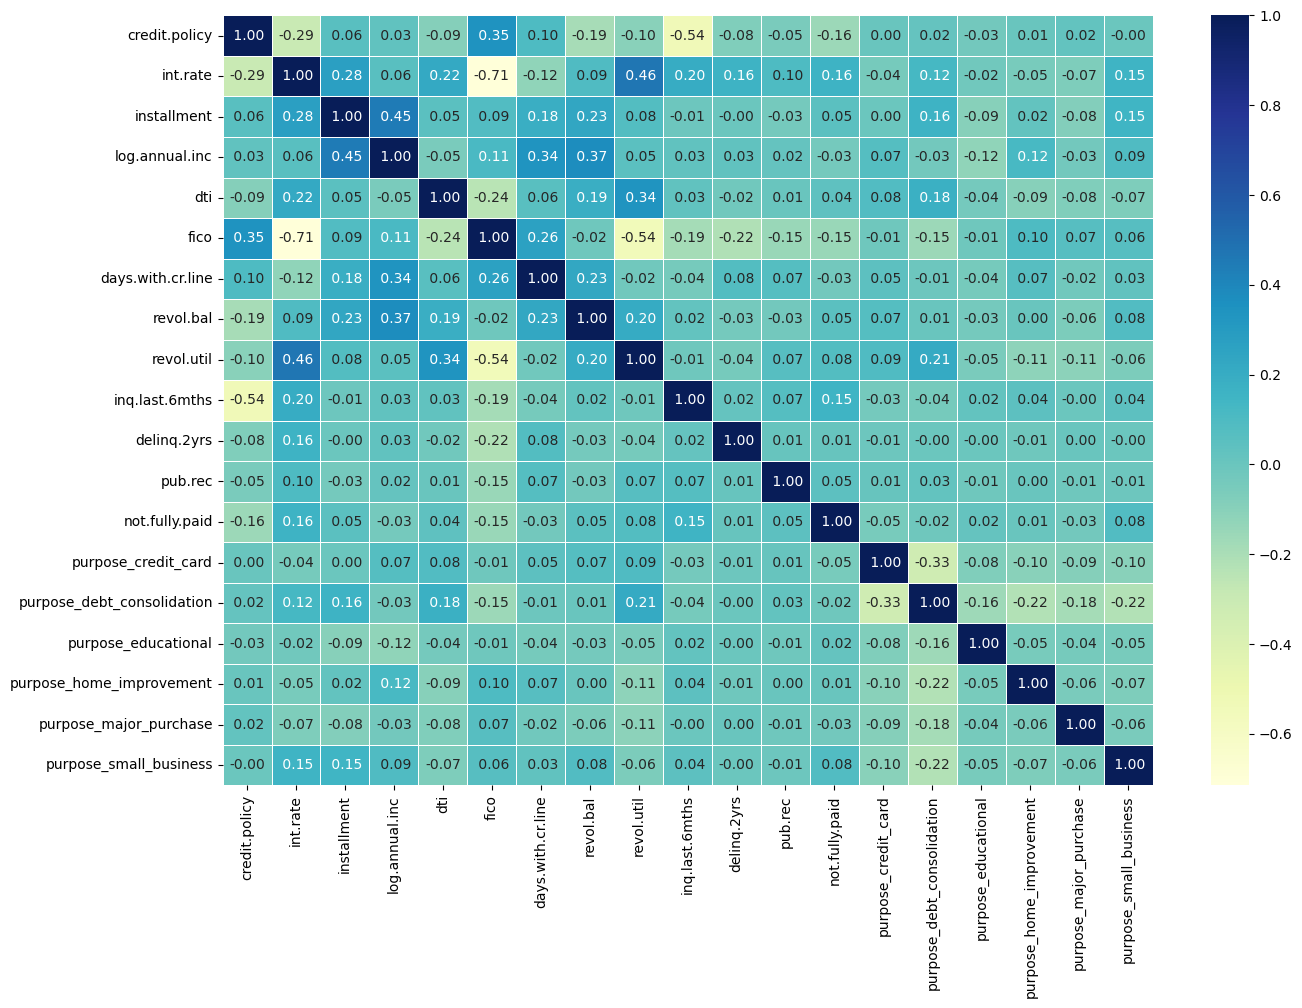

In [284]:
data_encoded = pd.get_dummies(data, drop_first=True)
corr_matrix = data_encoded.corr()
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(corr_matrix, annot=True, linewidth=0.5, fmt=" .2f", cmap="YlGnBu")

## 2. Modelling the Data

In [362]:
models = {'RandomForest': RandomForestRegressor(),
          'Linear Regression': LinearRegression(),
          'Lasso': Lasso(),
          'Gradient Boosting': GradientBoostingRegressor(),
          'XGBoost': XGBRegressor(),
          'CatBoost': CatBoostRegressor(verbose=0)}

In [260]:
def rmsle(y_test, y_preds):
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

def show_scores(models, X_train, X_test, y_train, y_test):
    model_scores={}
    for name, model in models.items():
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        scores = {
                  'MAE': mean_absolute_error(y_test, preds),
                  'RMSLE': rmsle(y_test, preds),
                  'MSE': mean_squared_error(y_test, preds),
                  'R^2': r2_score(y_test, preds)}
        model_scores[name] = scores
    return model_scores

In [261]:
data.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


#### Drop Columns with Noisy Data
* **int.rate**: target variable
* **revol.bal**: low correlation
* **installment**: can cause data leakage since it is directly involved with interest rate

In [313]:
X = data.drop(['int.rate', 'revol.bal', 'installment'], axis=1)
X.head()

,credit.policy,purpose,log.annual.inc,dti,fico,days.with.cr.line,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,11.350407,19.48,737,5639.958333,52.1,0,0,0,0
1,1,credit_card,11.082143,14.29,707,2760.000000,76.7,0,0,0,0
2,1,debt_consolidation,10.373491,11.63,682,4710.000000,25.6,1,0,0,0
3,1,debt_consolidation,11.350407,8.10,712,2699.958333,73.2,1,0,0,0
4,1,credit_card,11.299732,14.97,667,4066.000000,39.5,0,1,0,0


In [314]:
y = data['int.rate']
y

0       0.1189
1       0.1071
2       0.1357
3       0.1008
4       0.1426
         ...  
9573    0.1461
9574    0.1253
9575    0.1071
9576    0.1600
9577    0.1392
Name: int.rate, Length: 9578, dtype: float64

#### Data preprocessing

In [315]:
worded_features = ['purpose']
one_hot = OneHotEncoder()
transformer = ColumnTransformer([('one_hot',
                                   one_hot,
                                   worded_features)],
                                   remainder='passthrough')
transformed_X = transformer.fit_transform(X)
transformed_X

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 1.]])

#### Splitting data into training and testing sets

In [365]:
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(transformed_X, y, test_size=0.20)

scores = show_scores(models, X_train, X_test, y_train, y_test)
mae_scores={}
for name in scores:
    print(name)
    print('MAE: ', scores[name]['MAE'])
    print('RMSLE: ', scores[name]['RMSLE'])
    print('MSE: ', scores[name]['MSE'])
    print('R^2: ', scores[name]['R^2'])
    print('\n')
    mae_scores[name] = scores[name]['MAE']

RandomForest
MAE:  0.012169889352818373
RMSLE:  0.014144398246318909
MSE:  0.0002534319181753654
R^2:  0.6318675863360388


Linear Regression
MAE:  0.012969422137252015
RMSLE:  0.014893732585056772
MSE:  0.0002807644451180015
R^2:  0.592164658672581


Lasso
MAE:  0.020832114373551203
RMSLE:  0.023209336865915038
MSE:  0.0006804792338300006
R^2:  0.011543358067865328


Gradient Boosting
MAE:  0.011749296541691524
RMSLE:  0.0135936724550654
MSE:  0.00023402527920862528
R^2:  0.660057456402001


XGBoost
MAE:  0.012029988280672869
RMSLE:  0.0141863802494057
MSE:  0.00025507032151814147
R^2:  0.6294876596816783


CatBoost
MAE:  0.011628144026356558
RMSLE:  0.013636086142918854
MSE:  0.00023553419502138446
R^2:  0.6578656219078849




In [366]:
mae_scores

{'RandomForest': 0.012169889352818373,
 'Linear Regression': 0.012969422137252015,
 'Lasso': 0.020832114373551203,
 'Gradient Boosting': 0.011749296541691524,
 'XGBoost': 0.012029988280672869,
 'CatBoost': 0.011628144026356558}

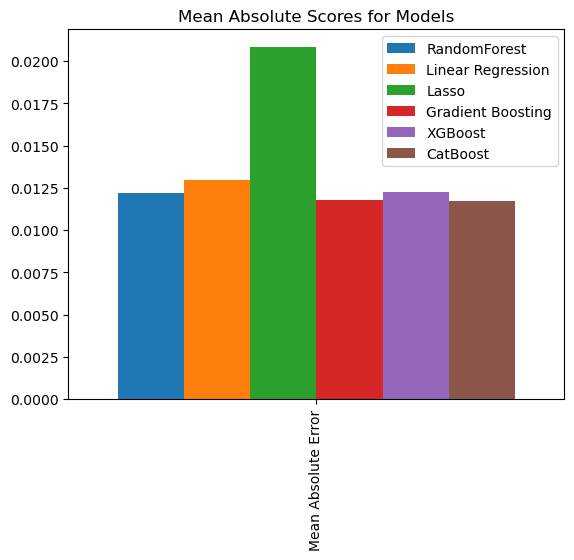

In [267]:
comparison = pd.DataFrame(mae_scores, index=["Mean Absolute Error"])
comparison.plot.bar(width=2);
plt.title("Mean Absolute Scores for Models");

## 3. Hypertuning Parameters

#### Tuning Random Forest

In [325]:
def show_tuned_scores(model, X_test, y_test, name):
    model_scores={}
    preds = model.predict(X_test)
    scores = {
                'MAE': mean_absolute_error(y_test, preds),
                'RMSLE': rmsle(y_test, preds),
                'MSE': mean_squared_error(y_test, preds),
                'R^2': r2_score(y_test, preds)}
    model_scores[name] = scores
    return model_scores

In [326]:
rf_params = {
    'n_estimators': [200, 300, 400, 500],  
    'max_depth': [None, 5, 7, 9], 
    'min_samples_split': [2, 3, 5],  
    'min_samples_leaf': [1, 2, 5, 10],  
    'max_features': ['sqrt', 'log2'],  
    'bootstrap': [True, False] 
}

In [327]:
np.random.seed(42)
rf = RandomizedSearchCV(RandomForestRegressor(), param_distributions=rf_params,
                               n_iter=10, cv=5, verbose=True)
rf.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 5, 7, 9],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 3, 5],
                                        'n_estimators': [200, 300, 400, 500]},
                   verbose=True)

In [328]:
rf.best_params_

{'n_estimators': 300,
 'min_samples_split': 3,
 'min_samples_leaf': 10,
 'max_features': 'log2',
 'max_depth': None,
 'bootstrap': False}

In [329]:
scores['RandomForest']

{'MAE': 0.012169889352818373,
 'RMSLE': 0.014144398246318909,
 'MSE': 0.0002534319181753654,
 'R^2': 0.6318675863360388}

In [330]:
rf_scores = show_tuned_scores(rf, X_test, y_test, name='Tuned Random Forest')
rf_scores

{'Tuned Random Forest': {'MAE': 0.011903362265480836,
  'RMSLE': 0.013797459103239696,
  'MSE': 0.000241295585439153,
  'R^2': 0.6494966896288579}}

#### Tuning Linear Regression

In [331]:
lr_params = {'copy_X': [True,False], 
               'fit_intercept': [True,False], 
               'n_jobs': [1,5,10,15,None], 
               'positive': [True,False]}

In [332]:
np.random.seed(42)
lr = GridSearchCV(LinearRegression(), lr_params, cv=5)
lr.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LinearRegression(),
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'n_jobs': [1, 5, 10, 15, None],
                         'positive': [True, False]})

In [333]:
lr.best_params_

{'copy_X': True, 'fit_intercept': False, 'n_jobs': 1, 'positive': False}

In [334]:
scores['Linear Regression']

{'MAE': 0.012969422137252015,
 'RMSLE': 0.014893732585056772,
 'MSE': 0.0002807644451180015,
 'R^2': 0.592164658672581}

In [335]:
lr_scores = show_tuned_scores(lr, X_test, y_test, name='Tuned Linear Regression')
lr_scores

{'Tuned Linear Regression': {'MAE': 0.012969422137261214,
  'RMSLE': 0.014893732585064472,
  'MSE': 0.00028076444511827744,
  'R^2': 0.59216465867218}}

#### Tuning Gradient Boosting

In [336]:
gb_params = {
    'n_estimators': np.arange(100, 501, 50),  
    'learning_rate': np.linspace(0.01, 0.1, 5),  
    'max_depth': np.arange(2, 6),  
    'subsample': np.linspace(0.6, 1.0, 5), 
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4]
}

In [337]:
np.random.seed(42)
gb = RandomizedSearchCV(GradientBoostingRegressor(), gb_params, n_iter=10, cv=5)
gb.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(),
                   param_distributions={'learning_rate': array([0.01  , 0.0325, 0.055 , 0.0775, 0.1   ]),
                                        'max_depth': array([2, 3, 4, 5]),
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': array([100, 150, 200, 250, 300, 350, 400, 450, 500]),
                                        'subsample': array([0.6, 0.7, 0.8, 0.9, 1. ])})

In [338]:
gb.best_params_

{'subsample': 0.8,
 'n_estimators': 450,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_depth': 3,
 'learning_rate': 0.05500000000000001}

In [339]:
scores['Gradient Boosting']

{'MAE': 0.011749296541691524,
 'RMSLE': 0.0135936724550654,
 'MSE': 0.00023402527920862528,
 'R^2': 0.660057456402001}

In [340]:
gb_scores = show_tuned_scores(gb, X_test, y_test, name='Tuned Gradient Boosting')
gb_scores

{'Tuned Gradient Boosting': {'MAE': 0.011626845833467367,
  'RMSLE': 0.013555727756802914,
  'MSE': 0.00023273181171092308,
  'R^2': 0.6619363330460846}}

#### Tuning XG Boost

In [341]:
xgb_params = {
  'n_estimators': [100, 200, 300, 500], 
    'learning_rate': [0.01, 0.05, 0.08, 0.1],
    'max_depth': [1, 3, 5, 7], 
    'subsample': [0.5, 0.7, 0.8, 1.0], 
    'colsample_bytree': [0.8, 1.0], 
    'gamma': [0, 0.1, 0.5],  
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0.5, 1, 1.5, 2],
    'min_child_weight': [1,3,5]
}

In [342]:
np.random.seed(42)
xgb = RandomizedSearchCV(XGBRegressor(), xgb_params, n_iter=20,cv=5)
xgb.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, ...),
                   n_iter=20,
                   param_distributions={'colsample_bytree': [0.8, 1.0],
                                        'gamma': [0, 0.1, 0.5],
                                        'learning_rate': [0.01, 0.05, 0.08,
                                                          0.1],
                                        'max_depth': [1, 3, 5, 7],
                                        'min_child_weight': [1, 3, 5],
                                        'n_estimators': [100, 200, 300, 500],
                                        'reg_alpha': [0, 0.1, 0.5, 1],
                                        'reg_lambda': [0.5, 1, 1.5, 2],
                                        'subsample': [0.5, 0.7, 0.8, 1.0]})

In [343]:
xgb.best_params_

{'subsample': 0.8,
 'reg_lambda': 0.5,
 'reg_alpha': 0,
 'n_estimators': 300,
 'min_child_weight': 3,
 'max_depth': 3,
 'learning_rate': 0.05,
 'gamma': 0,
 'colsample_bytree': 1.0}

In [344]:
scores['XGBoost']

{'MAE': 0.012029988280672869,
 'RMSLE': 0.0141863802494057,
 'MSE': 0.00025507032151814147,
 'R^2': 0.6294876596816783}

In [345]:
xgb_scores = show_tuned_scores(xgb, X_test, y_test, name='Tuned XG Boosting')
xgb_scores

{'Tuned XG Boosting': {'MAE': 0.01165341759258745,
  'RMSLE': 0.01351737642890571,
  'MSE': 0.0002314520531237148,
  'R^2': 0.6637952962777409}}

#### Tuning CatBoost

In [346]:
cat_params = {'iterations': [500, 1000],        
              'learning_rate': [0.01, 0.05, 0.1],   
              'depth': [4, 6, 8],             
              'l2_leaf_reg': [3, 5, 7],       
              'bagging_temperature': [0.1, 0.5, 1.0],  
              'random_strength': [1, 2, 5],  
              'min_data_in_leaf': [1, 5, 10], 
              'border_count': [32, 64, 128],
              'subsample': [0.8, 1.0] }

In [347]:
np.random.seed(42)
cat = RandomizedSearchCV(CatBoostRegressor(verbose=0), cat_params, n_iter=20, cv=5)
cat.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostRegressor object at 0x0000015D9FBB3FB0>,
                   n_iter=20,
                   param_distributions={'bagging_temperature': [0.1, 0.5, 1.0],
                                        'border_count': [32, 64, 128],
                                        'depth': [4, 6, 8],
                                        'iterations': [500, 1000],
                                        'l2_leaf_reg': [3, 5, 7],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'min_data_in_leaf': [1, 5, 10],
                                        'random_strength': [1, 2, 5],
                                        'subsample': [0.8, 1.0]})

In [348]:
cat.best_params_

{'subsample': 1.0,
 'random_strength': 1,
 'min_data_in_leaf': 1,
 'learning_rate': 0.05,
 'l2_leaf_reg': 7,
 'iterations': 500,
 'depth': 6,
 'border_count': 128,
 'bagging_temperature': 0.5}

In [349]:
scores['CatBoost']

{'MAE': 0.011628144026356558,
 'RMSLE': 0.013636086142918854,
 'MSE': 0.00023553419502138446,
 'R^2': 0.6578656219078849}

In [350]:
cat_scores = show_tuned_scores(cat, X_test, y_test, name='Tuned CatBoost')
cat_scores

{'Tuned CatBoost': {'MAE': 0.011562138220928952,
  'RMSLE': 0.01347509324718778,
  'MSE': 0.00022992175325985598,
  'R^2': 0.6660181930090128}}

In [351]:
cat_scores['Tuned CatBoost']['MAE']

0.011562138220928952

In [352]:
mae_scores

{'RandomForest': 0.012169889352818373,
 'Linear Regression': 0.012969422137252015,
 'Gradient Boosting': 0.011749296541691524,
 'XGBoost': 0.012029988280672869,
 'CatBoost': 0.011628144026356558}

In [367]:
del mae_scores['Lasso']

In [368]:
tuned_mae_scores = {'RandomForest': rf_scores['Tuned Random Forest']['MAE'],
                    'Linear Regression': lr_scores['Tuned Linear Regression']['MAE'],
                    'Gradient Boosting': gb_scores['Tuned Gradient Boosting']['MAE'],
                    'XGBoost': xgb_scores['Tuned XG Boosting']['MAE'],
                    'CatBoost': cat_scores['Tuned CatBoost']['MAE']}
tuned_mae_scores

{'RandomForest': 0.011903362265480836,
 'Linear Regression': 0.012969422137261214,
 'Gradient Boosting': 0.011626845833467367,
 'XGBoost': 0.01165341759258745,
 'CatBoost': 0.011562138220928952}

In [369]:
df = pd.DataFrame({
    'Original MAE': mae_scores,
    'Tuned MAE': tuned_mae_scores
})
df

,Original MAE,Tuned MAE
RandomForest,0.012170,0.011903
Linear Regression,0.012969,0.012969
Gradient Boosting,0.011749,0.011627
XGBoost,0.012030,0.011653
CatBoost,0.011628,0.011562


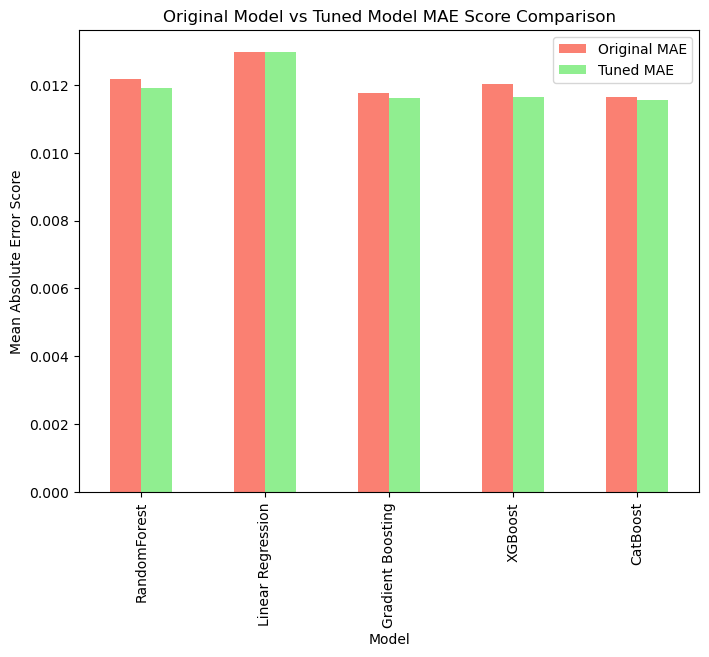

In [370]:
ax = df.plot(kind='bar', figsize=(8,6), color=['salmon', 'lightgreen']);
plt.title('Original Model vs Tuned Model MAE Score Comparison');
plt.xlabel('Model');
plt.ylabel('Mean Absolute Error Score');

Minimum MAE Score: 0.011562138220928952 (CatBoost)


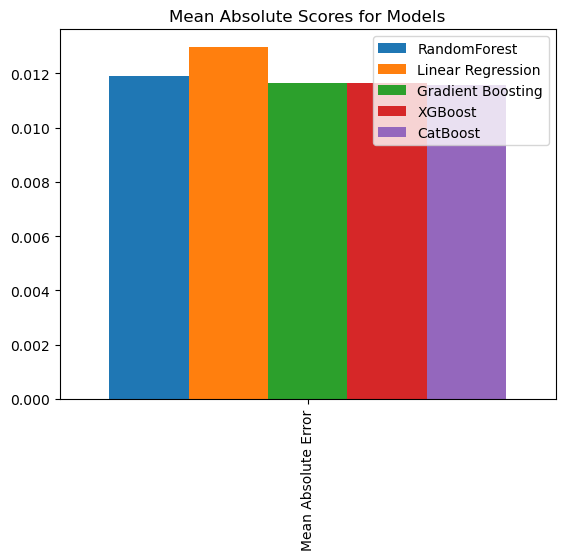

In [371]:
min_model = min(tuned_mae_scores, key=tuned_mae_scores.get)
min_mae = tuned_mae_scores[min_model]

print(f'Minimum MAE Score: {min_mae} ({min_model})')
comparison = pd.DataFrame(tuned_mae_scores, index=["Mean Absolute Error"])
comparison.plot.bar(width=2);
plt.title("Mean Absolute Scores for Models");

### 4. Comparing Model Performance for Training and Testing Data
The `CatBoostRegressor()` model has the lowest MAE so we will use this model

In [372]:
cat_scores

{'Tuned CatBoost': {'MAE': 0.011562138220928952,
  'RMSLE': 0.01347509324718778,
  'MSE': 0.00022992175325985598,
  'R^2': 0.6660181930090128}}

In [373]:
train_scores = show_tuned_scores(cat, X_train, y_train, name='CatBoost Train Scores')
train_scores

{'CatBoost Train Scores': {'MAE': 0.010725300401833423,
  'RMSLE': 0.012189627870250392,
  'MSE': 0.00018782450463172078,
  'R^2': 0.742202978602267}}

In [376]:
train_and_test_scores = {'Tuned CatBoost': {'MAE': 0.011562138220928952},
                         'CatBoost Training Scores': {'MAE': 0.010725300401833423}}
cat_df = pd.DataFrame(train_and_test_scores)
cat_df.T

,MAE
Tuned CatBoost,0.011562
CatBoost Training Scores,0.010725


MAE Difference Between Training and Testing Data =  0.0008368378190955292


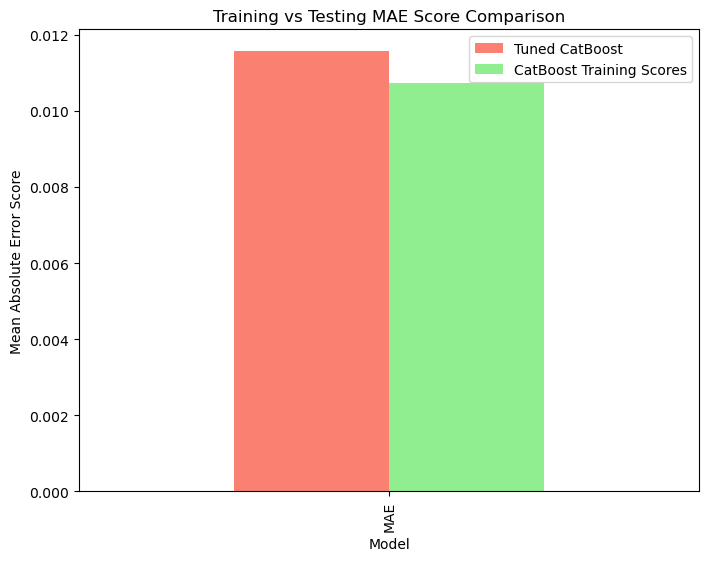

In [377]:
comp = cat_df.plot(kind='bar', figsize=(8,6), color=['salmon', 'lightgreen']);
plt.title('Training vs Testing MAE Score Comparison');
plt.xlabel('Model');
plt.ylabel('Mean Absolute Error Score');
diff = cat_scores['Tuned CatBoost']['MAE'] - train_scores['CatBoost Train Scores']['MAE']
print('MAE Difference Between Training and Testing Data = ', diff)

# Conclusion

In this project, I developed a model to predict loan interest rate using several features, including **debt-to-income ratio**, **FICO Credit score**, and **Annual Income**  
The model achieved:  
- **Mean Absolute Error**: 0.0116
- **R^2 Score**: 0.65
- **Mean Squared Error**: 0.0002
- **Root Mean Squared Log Error**: 0.0137 

This project showcases the potential of machine learning in financial services, enabling lenders to make data-driven decisions and improve customer experiences.  

**MAE (Mean Absolute Error) scores:**
* **Tuned CatBoost**: 0.011621
* **CatBoost Train Scores**: 0.010778
  
These MAE values are very close, indicating that the model is performing well on both the training and test sets. A slight difference between the train and test MAE is expected, but the small gap (around 0.0008) suggests the model is not overfitting significantly and generalizes well.  

For predicting loan interest rates, an MAE of around 0.0116 is generally considered quite good, depending on the scale and context of the data. Since the model has consistent performance across training and test data, it shows stability and reliability in its predictions.  
